In [149]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import matplotlib.pyplot as plt

from pathlib import Path
import os
import sys

import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "9"

import torch
from torch import nn
from torch import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary

from transformers import WhisperTokenizer, WhisperFeatureExtractor
from transformers import GenerationConfig
from transformers import WhisperForConditionalGeneration
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# import LORA modules
from peft import LoraConfig
from peft import LoraModel, AdaLoraModel, PeftModel, get_peft_model

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, QuantileTransformer

from dataclasses import dataclass
from typing import Any, Dict, List, Union

import evaluate
metric = evaluate.load("wer")

from pathlib import Path
with open("../../default_paths.txt", 'r') as file:
    lines = file.readlines()
    data_path    = Path(lines[0].strip().split("=")[1])
    project_path = Path(lines[1].strip().split("=")[1])
    
utils_path = project_path / "utils"
train_path = data_path / "train"
test_path  = data_path / "test"
sys.path.insert(0, str(utils_path))

from data_utils_lesha import (process_all_files, 
process_string, 
save_sentences_to_txt,
load_sentences_from_txt,
ModelAdaptationConfig,
PreprocessConfig,
AugmentConfig,
configure_input_layers,
configure_learnable_layers,
WhisperAugmentDataset,
DataCollatorSpeechSeq2SeqWithPadding,
count_parameters, 
compute_metrics, 
save_config, 
load_config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cuda')

In [60]:
""" LOAD PRETRAINED MODEL COMPONENTS """

WHISPER_MODEL_NAME = "openai/whisper-large-v3"

# load feature/label processing engines
feature_extractor = WhisperFeatureExtractor.from_pretrained(WHISPER_MODEL_NAME)
tokenizer = WhisperTokenizer.from_pretrained(WHISPER_MODEL_NAME, task="transcribe")
# load model
model = WhisperForConditionalGeneration.from_pretrained(WHISPER_MODEL_NAME)

if ".en" not in WHISPER_MODEL_NAME:
    model.generation_config.language = "english"
    model.generation_config.task = "transcribe"
    model.generation_config.forced_decoder_ids = None

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Adapt model

In [59]:
lora_config = LoraConfig(r=8, 
                         task_type="SEQ_2_SEQ_LM", 
                         use_rslora=True, 
                         use_dora=True)

adaptation_config = ModelAdaptationConfig(fs_whisper=100, 
                                          inputs_stack="stack",
                                          conv1_time_kernel_size=9, 
                                          conv2_time_kernel_size=3,
                                          conv1_out_channels=1280, 
                                          conv_layer_idx_stride_2=2,
                                          adapt_model="full",  # EXCLUSIVE
                                          freeze_modules=("decoder"), 
                                          low_rank_adaptation_modules=("decoder"), 
                                          low_rank_adaptation_targets=("q_proj", "k_proj", "v_proj", "out_proj", "fc1", "fc2"), 
                                          lora_config=lora_config,
                                          n_electrodes=256, n_features=2, max_duration=30)

In [58]:
model = configure_input_layers(model, adaptation_config)

Input size:  torch.Size([10, 256, 2, 3000])
Conv1 output size:  torch.Size([10, 1280, 3000])
Conv2 output size:  torch.Size([10, 1280, 1500])

 Number of parameters conv1:
CustomConv1dWrapper(
  (conv1): Conv2d(256, 1280, kernel_size=(2, 9), stride=(1, 1), padding=(0, 4))
)
Total: 5.90M, Trainable: 5.90M

Number of parameters conv2: 
Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
Total: 4.92M, Trainable: 4.92M


In [50]:
model = configure_learnable_layers(model, adaptation_config)
model

Full model parameters: 
Total: 1548.90M, Trainable: 1546.98M

Returning full model...


WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): CustomConv1dWrapper(
        (conv1): Conv2d(256, 1280, kernel_size=(2, 9), stride=(1, 1), padding=(0, 4))
      )
      (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 1280)
      (layers): ModuleList(
        (0-31): 32 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=False)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (f

## Load data and scale dataset

In [148]:
%%time
data_train = process_all_files(train_path)
data_test = process_all_files(test_path)

print(data_train.keys())

# XV = np.concatenate(data_train['voltage_list'], axis=0)
# # scalerV = RobustScaler(quantile_range=(0.01, 0.99), unit_variance=True).fit(XV)
# #scalerV = QuantileTransformer(n_quantiles=3000, output_distribution='uniform', subsample=30000).fit(XV)
# scalerV = StandardScaler().fit(XV)

# XS = np.concatenate(data_train['spike_list'], axis=0)
# scalerS = MinMaxScaler(feature_range=(-1, 1)).fit(XS)

dict_keys(['voltage_list', 'spike_list', 'sentence_list', 'date_list'])
CPU times: user 15.7 s, sys: 4.14 s, total: 19.8 s
Wall time: 22.1 s


## Define train and eval datasets with augmentations

In [147]:
check_augments = True
n_train = 100 if check_augments else len(data_train['voltage_list'])

preprocess_config = PreprocessConfig(inputs_stack=adaptation_config.inputs_stack,
                                     voltage_scaler=StandardScaler(), 
                                     spike_scaler=MinMaxScaler(feature_range=(-1, 1)), 
                                     sentence_tokenizer=tokenizer,
                                     eval_filter_freq=5,
                                     filter_voltage=True,
                                     filter_spikes=False,
                                     fs_orig=50,  
                                     fs_whisper=adaptation_config.fs_whisper,
                                     max_duration=30.0,
                                     resample_type='fft_resample')

augment_config = AugmentConfig(total_augment_probability=1, 
                               channel_mask_probability=0,
                               channel_mask_fraction_limits=(0.01, 0.02),
                               time_mask_probability=0.2,
                               time_mask_fraction_limits=(0.01, 0.02),
                               time_stretch_probability=0, 
                               time_stretch_limits=(0.95, 1.05),
                               voltage_noise_probability=1,
                               voltage_noise_snr_limits=(8, 20),
                               voltage_drift_limits=(-0.2, 0.2),
                               spike_noise_probability=0.2,
                               spike_noise_per_bin_probability=0.005,
                               no_filter_probability=0,
                               filter_cutoff_freq_limits=(preprocess_config.eval_filter_freq, 25),
                               random_signal_shift_probability=0)


train_dataset = WhisperAugmentDataset(data_train['voltage_list'][:n_train], 
                                           data_train['spike_list'][:n_train], 
                                           data_train['sentence_list'][:n_train],
                                           preprocess_config, 
                                           augment_config, 
                                           is_eval=False)


# eval_dataset = WhisperAugmentDataset(data_test['voltage_list'], 
#                                            data_test['spike_list'], 
#                                            data_test['sentence_list'],
#                                            preprocess_config, 
#                                            augment_config, 
#                                            is_eval=True)

Fitting scalers...


Processing dataset...: 100%|██████████| 100/100 [00:01<00:00, 86.96it/s]


Input processing time ~ 36.2 ms


Original shape (256, 591)
the eastern coast is a place for pure pleasure and excitement


torch.Size([256, 2, 3000])

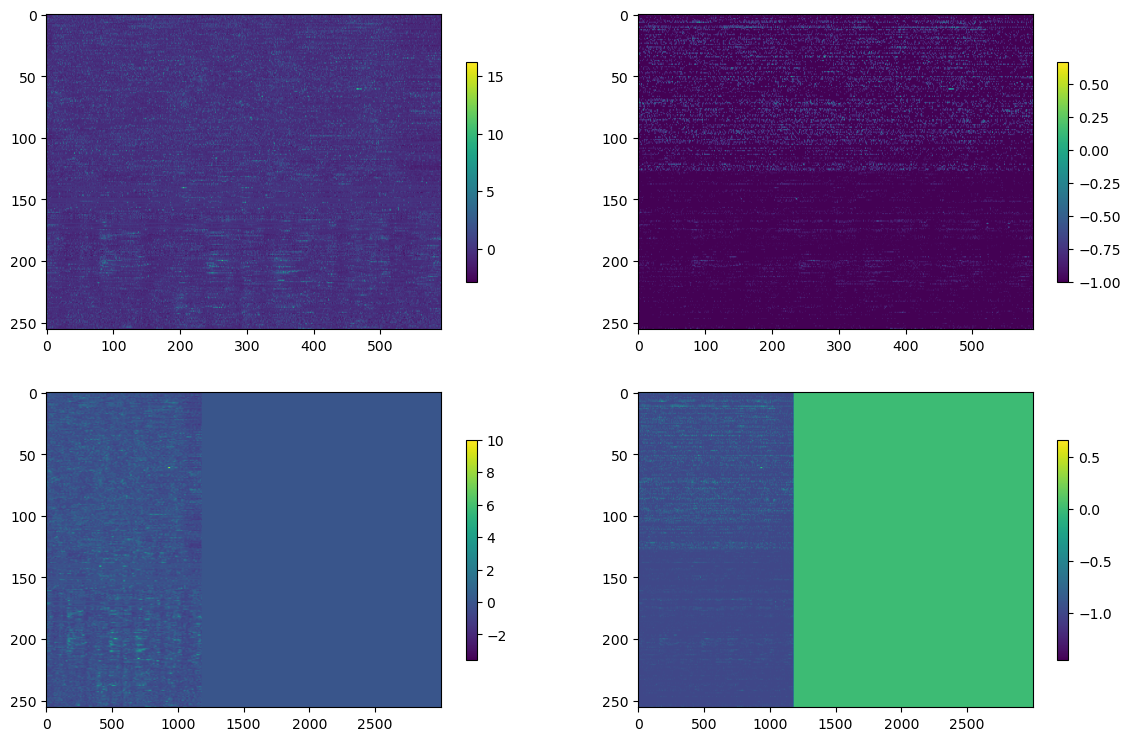

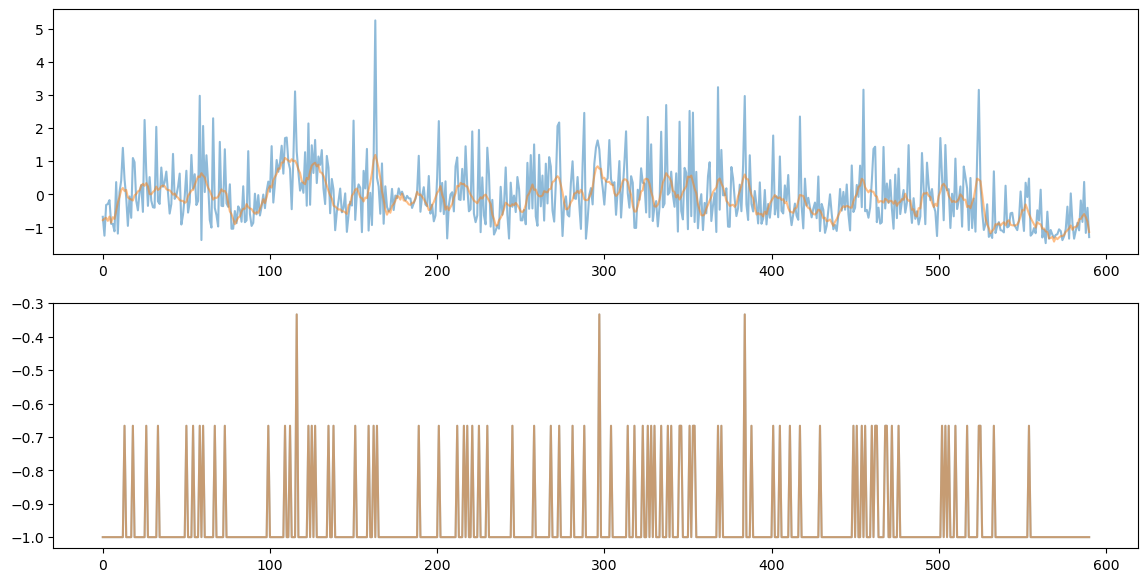

In [143]:
idx = 10
chan = 3

dataset = train_dataset
data = data_train

voltage = scalerV.transform(data['voltage_list'][idx]).T
spikes = scalerS.transform(data['spike_list'][idx]).T

print("Original shape", voltage.shape)

plt.figure(figsize=(14, 9))

# with scaling
plt.subplot(221)
plt.imshow(voltage, aspect='auto')
plt.colorbar(shrink=0.7)

plt.subplot(222)
plt.imshow(spikes, aspect='auto')
plt.colorbar(shrink=0.7)

# Augmentations etc.
input_features = dataset[idx]['input_features'].numpy()
if adaptation_config.inputs_stack == "concat":
    cfg = adaptation_config
    input_features = np.empty((cfg.n_electrodes, cfg.n_features, (cfg.max_duration * cfg.fs_whisper)))
    input_features[:, 0, :] = input_features[:cfg.n_electrodes, :]
    input_features[:, 1, :] = input_features[cfg.n_electrodes:, :]
    
plt.subplot(223)
plt.imshow(input_features[:, 0], aspect='auto')
plt.colorbar(shrink=0.7)

plt.subplot(224)
plt.imshow(input_features[:, 1], aspect='auto')
plt.colorbar(shrink=0.7)


plt.figure(figsize=(14, 7))

plt.subplot(211)
plt.plot(voltage[chan], alpha=0.5)
plt.plot(input_features[chan, 0, 0:voltage.shape[1]*2:2], alpha=0.5)


plt.subplot(212)
plt.plot(spikes[chan], alpha=0.5)
plt.plot(input_features[chan, 1, 0:voltage.shape[1]*2:2], alpha=0.5)

print(data_train['sentence_list'][idx])
dataset[0]['input_features'].shape

## Training setup

### Setup wandb and hugging face login

## Set training parameters

In [14]:
import wandb
wandb.login(key="84800673dd80a5eac8bb77b02728e733f806fd10")

experiment_path = data_path / "experiments" / WHISPER_MODEL_NAME / "decoder-DORA-12-conv2d_augment-smart_no-filter_LR-0.5e-4"
experiment_path.mkdir(parents=True, exist_ok=True)


config_names = ["augment_config.json", "preprocess_config.json", "adaptataion_config.json"]
configs = [augment_config, preprocess_config, adaptation_config]

for i in range(len(config_names)):
    save_config(configs[i], experiment_path / config_names[i])

batch_size = 16
epoch_length = int(len(train_dataset) / batch_size)

training_args = Seq2SeqTrainingArguments(
    output_dir=experiment_path,  # change to a repo name of your choice
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=int(16 / batch_size),  # increase by 2x for every 2x decrease in batch size
    learning_rate=0.5e-4,
    num_train_epochs=24,
    weight_decay=1e-5,
    warmup_steps=4 * epoch_length,
    gradient_checkpointing=True,
    fp16=False,
    evaluation_strategy="steps",
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    generation_max_length=32,
    save_steps=int(epoch_length / 2),
    eval_steps=int(epoch_length / 2),
    logging_steps=int(epoch_length / 16),
    report_to=["wandb"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
)

# initialize data collator
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

# initialize trainer
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

## Train

In [ ]:
trainer.train()

`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Step,Training Loss,Validation Loss,Wer
275,3.179700,3.060718,96.180429
550,3.110700,2.952002,105.056384


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}


### Evaluate from checkpoint

In [32]:
experiment_path

PosixPath('/mnt/beegfs/home/atimcenko/at_code/brain2text/data/experiments/openai/whisper-large-v3/experiment-6_features-512_interleave_augment-eval_model-max')

In [29]:
checkpoint_path = experiment_path / "checkpoint-1375"
model = WhisperForConditionalGeneration.from_pretrained(checkpoint_path).to('cuda')

In [21]:
for idx in range(0, 10):
    true_text = data_test['sentence_list'][idx]
    print(f"True: {true_text}")
    input_tensor = train_dataset[idx]['input_features'].to('cuda').type(torch.float).reshape((1, 512, 3000))
    ids = model.generate(input_tensor).cpu()
    pred_text = tokenizer.decode(ids[0], skip_special_tokens=True)
    print(f"Pred: {pred_text}\n")

True: Theocracy reconsidered.
Pred: Nuclear rockets can destroy airfields with ease.

True: Rich purchased several signed lithographs.
Pred: The best way to learn is to solve extra problems.

True: So rules we made, in unabashed collusion.
Pred: The spray will be used in first division matches next season.

True: Lori's costume needed black gloves to be completely elegant.
Pred: Our experiment's positive outcome was unexpected.

True: The tooth fairy forgot to come when Roger's tooth fell out.
Pred: Alimony harms a divorced man's wealth.

True: That stinging vapor was caused by chloride vaporization.
Pred: She uses both names interchangeably.

True: Before Thursday's exam, review every formula.
Pred: The misquote was retracted with an apology.

True: Wildfire near Sunshine forces park closures.
Pred: Critics fear the erosion of consumer protections and environmental standards.

True: The word means it won't boil away easily, nothing else.
Pred: Her lips, moist and parted, spoke his nam

**Change num_beans**

In [31]:
for idx in range(20, 30):
    true_text = sentences_test[idx]
    print(f"True: {true_text}")
    input_tensor = eval_dataset[idx]['input_features'].to('cuda').type(torch.float).reshape((1, 80, 3000))
    ids = model.generate(input_tensor).cpu()
    pred_text = tokenizer.decode(ids[0], skip_special_tokens=True)
    print(f"Pred: {pred_text}\n")

True: to some extent predispositions are shaped by exposure to group environments
Pred: the last time we talked about the explosion the explosion happened

True: an adult male baboon's teeth are not suitable for eating shellfish
Pred: in a long long long long time there was not much to say

True: in this context it would do well for us to bear in mind the vision of peace
Pred: in the long run we have to go where we need to be before we can go where we need to be before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before we can go before

In [39]:
model

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        

In [8]:
model.encoder

NameError: name 'model' is not defined